In [1]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# redukcja wymiarowości
from sklearn.decomposition import PCA

# model
from sklearn.linear_model import LogisticRegression

# ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

In [3]:
#Wczytanie danych i podział na dane treningowe i testowe
dataset = pd.read_csv('titanic.csv')
dataset

X = dataset.drop(['Survived'], axis=1).copy()
y = dataset['Survived'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 333, stratify = y)



In [5]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))
])


#przekształcenie w pandas DataFrame, bo transform zwraca numpy array
print('Surowy zbiór danych - zbiór treningowy:')
print(X_train[num_features].isnull().mean())
X_train_trasnformed = num_preparation.fit_transform(X_train[num_features])
X_train_trasnformed = pd.DataFrame(X_train_trasnformed, columns=num_features)
print('\nWyjście Pipeline - zbiór treningowy')
print(X_train_trasnformed[num_features].isnull().mean())

#Transformacja zbioru testowego - nie można filtrować!
print('Surowy zbiór danych - zbiór testowy:')
print(X_test[num_features].isnull().mean())
X_test_trasnformed = num_preparation.transform(X_test[num_features])
X_test_trasnformed = pd.DataFrame(X_test_trasnformed, columns=num_features)
print('\nWyjście Pipeline - zbiór testowy')
print(X_test_trasnformed[num_features].isnull().mean())



Surowy zbiór danych - zbiór treningowy:
Age      0.188623
SibSp    0.000000
Parch    0.000000
Fare     0.000000
dtype: float64

Wyjście Pipeline - zbiór treningowy
Age      0.0
SibSp    0.0
Parch    0.0
Fare     0.0
dtype: float64
Surowy zbiór danych - zbiór testowy:
Age      0.2287
SibSp    0.0000
Parch    0.0000
Fare     0.0000
dtype: float64

Wyjście Pipeline - zbiór testowy
Age      0.0
SibSp    0.0
Parch    0.0
Fare     0.0
dtype: float64


In [ ]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))
])

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

data_preparation.fit_transform(X_train)

In [ ]:
#utworzenie klasy custom transformatora
class Filter_Name(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y = None ):
        return self

    def transform(self, X, y = None ):
        X_transformed = X.copy()
        column = self.column
        X_transformed[column] = X_transformed[column].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
        X_transformed.loc[~X_transformed[column].isin(['Mr', 'Miss', 'Mrs']), column] = 'Other'
        return X_transformed
    

#użycie tranformatora dla kolumny Name
transformer_filter_name = Filter_Name(column='Name')
display(X_train[['Name']])
display(transformer_filter_name.fit_transform(X_train[['Name']]))



In [7]:
cat_features = ['Name', 'Sex', 'Embarked']

# przygotowanie wartości kategorycznych
cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name'))
])

print('Przed')
display(X_train[cat_features])
print('Po')
display(cat_preparation.fit_transform(X_train[cat_features]))

print(cat_preparation.fit_transform(X_train[cat_features]).shape)

Przed


,Name,Sex,Embarked
102,"White, Mr. Richard Frasar",male,S
713,"Larsson, Mr. August Viktor",male,S
300,"Kelly, Miss. Anna Katherine ""Annie Kate""",female,Q
673,"Wilhelms, Mr. Charles",male,S
408,"Birkeland, Mr. Hans Martin Monsen",male,S
...,...,...,...
786,"Sjoblom, Miss. Anna Sofia",female,S
704,"Hansen, Mr. Henrik Juul",male,S
735,"Williams, Mr. Leslie",male,S
519,"Pavlovic, Mr. Stefo",male,S


Po


,Name,Sex,Embarked
102,Mr,male,S
713,Mr,male,S
300,Miss,female,Q
673,Mr,male,S
408,Mr,male,S
...,...,...,...
786,Miss,female,S
704,Mr,male,S
735,Mr,male,S
519,Mr,male,S


(668, 3)


In [9]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Name', 'Sex', 'Embarked']

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))
])

# przygotowanie wartości kategorycznych
cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False ,handle_unknown='ignore'))
])

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)
])


#Trenowanie modelu
model_pipeline_v1 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])


model_pipeline_v1.fit(X_train, y_train)




,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric_preprocessing', ...), ('categorical_preprocessing', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


              precision    recall  f1-score   support

           0       0.84      0.87      0.85       137
           1       0.78      0.73      0.75        86

    accuracy                           0.82       223
   macro avg       0.81      0.80      0.80       223
weighted avg       0.81      0.82      0.82       223



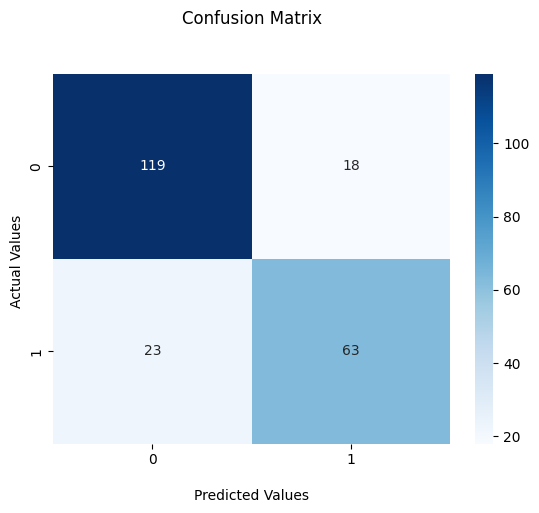

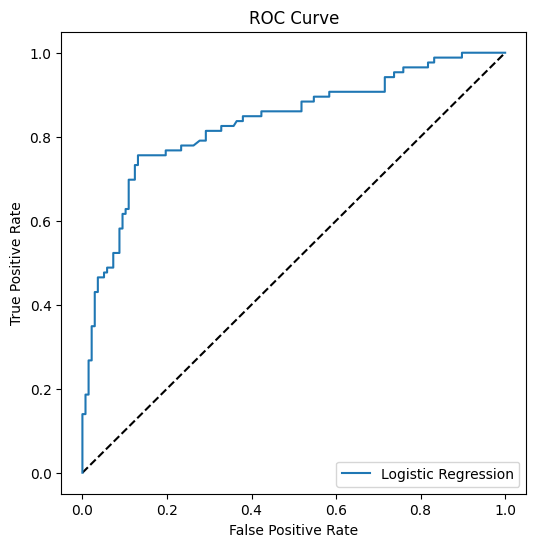

C:\Users\kkleps\AppData\Local\Temp\ipykernel_92352\2426133575.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)


,Model,F1_score,AUC
0,Logistic Regression,0.754491,0.83513


In [12]:
#Ocena modelu - funkcja metryk

metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################

    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    new_row = pd.DataFrame([{'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric}])
    metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)
    return metrics_dataframe

calculate_metrics(model_pipeline_v1, 'Logistic Regression', X_test, y_test)

In [15]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Name', 'Sex', 'Embarked']

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean')),
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])

# przygotowanie wartości kategorycznych
cat_preparation = Pipeline(steps=[
    ('filter_name', Filter_Name(column='Name')),
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False ,handle_unknown='ignore'))
])

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)
])

model_pipeline_v2 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])
model_pipeline_v2.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric_preprocessing', ...), ('categorical_preprocessing', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
Wybrane hiperparametry:  {'model__C': np.float64(1.2067926406393288), 'preprocessor__numeric_preprocessing__fill_missings__strategy': 'mean', 'preprocessor__numeric_preprocessing__pca__n_components': 0.99, 'preprocessor__numeric_preprocessing__polynomial_features__degree': 2}
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       137
           1       0.79      0.74      0.77        86

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.81       223
weighted avg       0.82      0.83      0.82       223



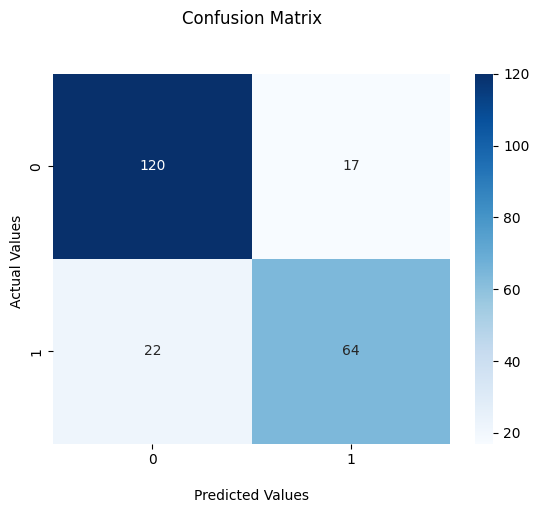

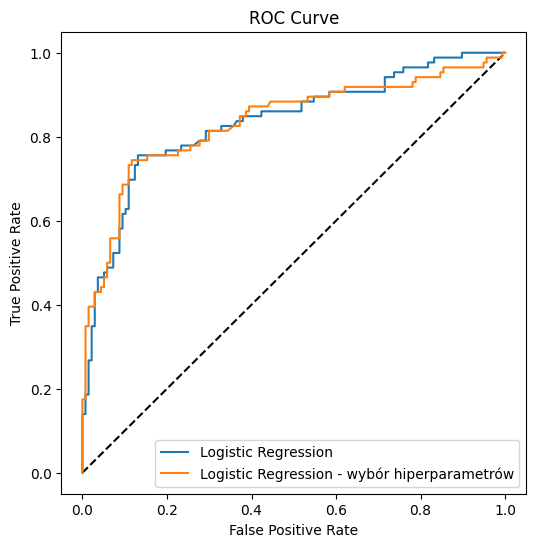

,Model,F1_score,AUC
0,Logistic Regression,0.754491,0.835130
1,Logistic Regression - wybór hiperparametrów,0.766467,0.835215


In [16]:
model_pipeline_v3 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])

list(model_pipeline_v3.get_params().keys())

#Utworzenie GridSearch
params = {
    'preprocessor__numeric_preprocessing__fill_missings__strategy': ['mean', 'median'],
    'preprocessor__numeric_preprocessing__polynomial_features__degree': [1, 2, 3, 4],
    'preprocessor__numeric_preprocessing__pca__n_components': [0.85, 0.90, 0.95, 0.99, 0.99999],
    'model__C': np.logspace(-4, 4, 50)
}

grid_search = GridSearchCV(model_pipeline_v3, params, cv=10, n_jobs=-1, verbose=10, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print('Wybrane hiperparametry: ', grid_search.best_params_)
model_v3 = grid_search.best_estimator_

calculate_metrics(model_v3, 'Logistic Regression - wybór hiperparametrów', X_test, y_test)